In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import os
#os.makedirs("../out", exist_ok=True)
import time
from tqdm import tqdm
from scipy.ndimage import affine_transform
import cv2
import scipy.ndimage
from scipy.interpolate import RectBivariateSpline
from scipy.ndimage.morphology import binary_opening, binary_closing
from scipy.ndimage import affine_transform

# Q2: Affine Motion Subtraction

Make sure to comment your code and use proper names for your variables.

## Q2.1: Lucas-Kanade Tracking with Affine Motion

In [3]:
# We recommend using this function, but you can explore other methods as well (e.g., ndimage.shift).
from scipy.interpolate import RectBivariateSpline

# The function below could be useful as well :) 
# from numpy.linalg import lstsq

def LucasKanadeAffine(It, It1, threshold, num_iters):
    """
    :param[np.array(H, W)] It   : Image frame at time-step t
    :param[np.array(H, W)] It1  : Image frame at time-step t+1
    :param[float] threshold     : If the length of dp < threshold, terminate the optimization
    :param[int] num_iters       : Number of iterations for running the optimization

    :return[np.array(2, 3)] M   : Affine warp matrix
    """
    # Initial M
    # M = np.eye(3)
    M = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0]])
    
    # ----------------------------------------------------------------------------------------------
    # TODO: Add your LK implementation here: 
    p=[1,0,0,0,1,0]
    it1_rbs=RectBivariateSpline(np.arange(It1.shape[0]), np.arange(It1.shape[1]), It1)
    dp=np.ones((1,5))
    while np.linalg.norm(dp)>=threshold:
        coord_x,coord_y=np.meshgrid(np.arange(0,It.shape[1]), np.arange(0, It.shape[0]))
        coord_xn = p[0]*coord_x+p[1]*coord_x+p[2]
        coord_yn = p[3]*coord_y+p[4]*coord_y+p[5]
        coord_x,coord_y=coord_x.flatten(),coord_y.flatten()
        gintx,ginty = it1_rbs.ev(coord_yn,coord_xn, dx=0, dy=1).flatten(),it1_rbs.ev(coord_yn, coord_xn, dx=1, dy=0).flatten()
        A=np.column_stack([np.multiply(gintx,coord_x.flatten()),np.multiply(gintx,coord_y.flatten()),gintx,np.multiply(ginty,coord_x.flatten()),np.multiply(ginty,coord_y.flatten()),ginty])
        Iint = it1_rbs.ev(coord_yn,coord_xn)
        b=It.flatten()-Iint.flatten()
        dp,_,_,_ = np.linalg.lstsq(np.dot(np.transpose(A),A),np.dot(np.transpose(A), b),rcond=None)
        p+=dp.flatten()
    M = np.reshape(p, (2, 3))
    # ----------------------------------------------------------------------------------------------
    return M

# Q2.2: Dominant Motion Subtraction

In [4]:
# These functions could be useful for your implementation. 
from scipy.ndimage import binary_erosion, binary_dilation, affine_transform
import cv2

def SubtractDominantMotion(It, It1, num_iters, threshold, tolerance):
    """
    :param[np.array(H, W)] It   : Image frame at time-step t
    :param[np.array(H, W)] It1  : Image frame at time-step t+1
    :param[float] threshold     : For LucasKanadeAffine --> If the length of dp < threshold, 
                                  terminate the optimization
    :param[int] num_iters       : For LucasKanadeAffine --> Number of iterations for running the 
                                  optimization
    :param[float] tolerance     : Binary threshold of intensity difference when computing the mask.
   
    :return[np.array(H, W)] mask: Binary mask indicating moving pixels. 
    """
    mask = np.zeros(It1.shape, dtype=bool)

    # ----------------------------------------------------------------------------------------------
    # TODO: Add your code here:
    M = LucasKanadeAffine(It,It1, threshold, num_iters)
    if M.shape[0] < 3:
        M = np.vstack((M, np.array([[0, 0, 1]])))
    M = np.linalg.inv(M)
    warp_image1 = scipy.ndimage.affine_transform(It,M[0:2,0:2],offset = M[0:2,2],output_shape = It1.shape)
    diff=abs(warp_image1-It1)
    mask[abs(warp_image1-It1)>tolerance]=1
    mask[warp_image1==0]=0
    # ----------------------------------------------------------------------------------------------
    return mask 

## Q2.3: Track Sequence

In [5]:
def TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance):
    """
    :param[np.array(H, W, N)] seq : sequence of frames
    :param[int] num_iters         : Number of iterations for running the optimization
    :param[float] threshold       : If the length of dp < threshold, terminate the optimization
    :param[float] tolerance       : Binary threshold of intensity difference when computing the mask.

    :return[np.array(H, W)] mask: Binary mask indicating moving pixels.
    """
    H, W, N = seq.shape

    masks = []
    It = seq[:,:,0]

    # ----------------------------------------------------------------------------------------------
    # TODO: Add your code here:
    for i in tqdm(range(1, seq.shape[2])):
        It1 = seq[:,:,i]
        mask = SubtractDominantMotion(It,It1,num_iters, threshold, tolerance)
        masks.append(mask)
        It=It1
    # ----------------------------------------------------------------------------------------------
    masks = np.stack(masks, axis=2)
    return masks

### Q2.3: Track Ant Sequence

Feel free to play with these snippets of code; run ablations, visualize a gif with the whole sequence, etc.

Just make sure the bounding boxes for the car are clearly visible, and report those of the frames we requested. 

In [16]:
seq = np.load(r"C:\Users\balub\Downloads\hw2-s23\hw2\data\antseq.npy")

# NOTE: feel free to play with these parameters
num_iters = 1e4
threshold = 1e-2
tolerance = 0.2

masks = TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)
np.save(r'C:\Users\balub\OneDrive\Desktop\CV HW2\antseqmasks.npy', masks)

100%|████████████████████████████████████████████████████████████████████████████████| 124/124 [00:14<00:00,  8.65it/s]


In [8]:
import cProfile
cProfile.run('TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)')

100%|████████████████████████████████████████████████████████████████████████████████| 124/124 [00:14<00:00,  8.72it/s]

         159707 function calls (158206 primitive calls) in 14.250 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      124    0.113    0.001   14.167    0.114 1765699338.py:5(SubtractDominantMotion)
        1    0.002    0.002   14.249   14.249 2181175384.py:1(TrackSequenceAffineMotion)
      124    0.312    0.003   13.347    0.108 3095406773.py:7(LucasKanadeAffine)
      248    0.000    0.000    0.002    0.000 <__array_function__ internals>:2(all)
      124    0.000    0.000    0.001    0.000 <__array_function__ internals>:2(atleast_2d)
      376    0.001    0.000    0.015    0.000 <__array_function__ internals>:2(broadcast_arrays)
      376    0.001    0.000    0.335    0.001 <__array_function__ internals>:2(column_stack)
      501    0.001    0.000    0.347    0.001 <__array_function__ internals>:2(concatenate)
      124    0.000    0.000    0.001    0.000 <__array_function__ internals>:2(copyto)
      248    0.000    0

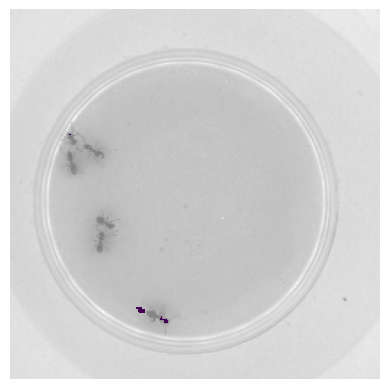

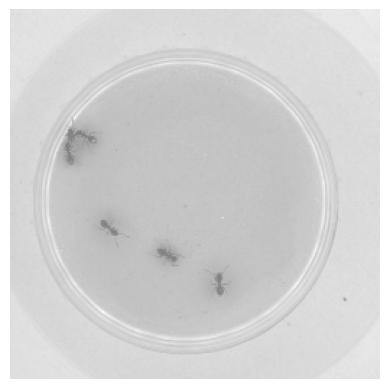

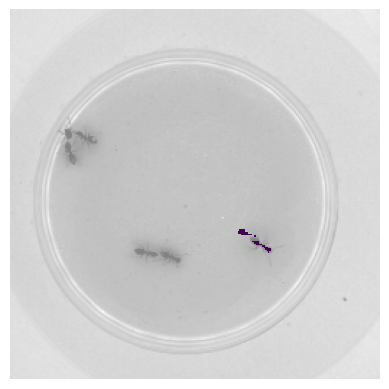

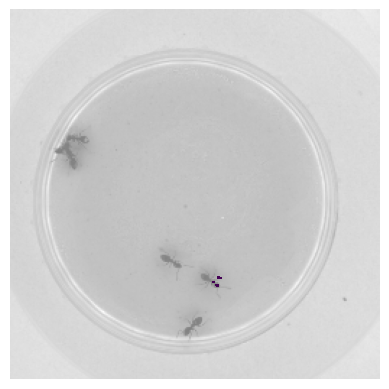

In [19]:
# # TODO: visualize
frames_to_save = [30,60,90,120]

for idx in frames_to_save:
    frame = seq[:,:,idx]
    mask = masks[:,:,idx-1]
    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask))
    plt.axis('off')
    plt.savefig(f"C:\\Users\\balub\\OneDrive\\Desktop\\CV HW2\\antseq_images_Affine\\sol_2.3_antseq_{idx+1}.png")

### Q2.3: Test Aerial Sequence

Feel free to play with these snippets of code; run ablations, visualize a gif with the whole sequence, etc.

Just make sure the bounding boxes for the car are clearly visible, and report those of the frames we requested. 

In [22]:
seq = np.load(r"C:\Users\balub\Downloads\hw2-s23\hw2\data\aerialseq.npy")

# NOTE: feel free to play with these parameters
num_iters = 1000
threshold = 0.01
tolerance = 0.2

masks = TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)
np.save(r'C:\Users\balub\OneDrive\Desktop\CV HW2\aerialseqmasks.npy', masks)

100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [00:54<00:00,  2.74it/s]


In [13]:
import cProfile
cProfile.run('TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)')

100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [00:57<00:00,  2.58it/s]

         349387 function calls (345357 primitive calls) in 57.818 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      149    0.133    0.001   57.665    0.387 1765699338.py:5(SubtractDominantMotion)
        1    0.002    0.002   57.817   57.817 2181175384.py:1(TrackSequenceAffineMotion)
      149    1.250    0.008   56.566    0.380 3095406773.py:7(LucasKanadeAffine)
      298    0.000    0.000    0.003    0.000 <__array_function__ internals>:2(all)
      149    0.000    0.000    0.001    0.000 <__array_function__ internals>:2(atleast_2d)
     1194    0.001    0.000    0.046    0.000 <__array_function__ internals>:2(broadcast_arrays)
     1194    0.002    0.000    1.489    0.001 <__array_function__ internals>:2(column_stack)
     1344    0.002    0.000    1.524    0.001 <__array_function__ internals>:2(concatenate)
      149    0.000    0.000    0.001    0.000 <__array_function__ internals>:2(copyto)
      298    0.000    0

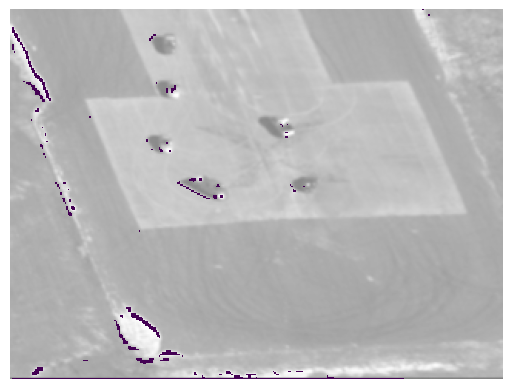

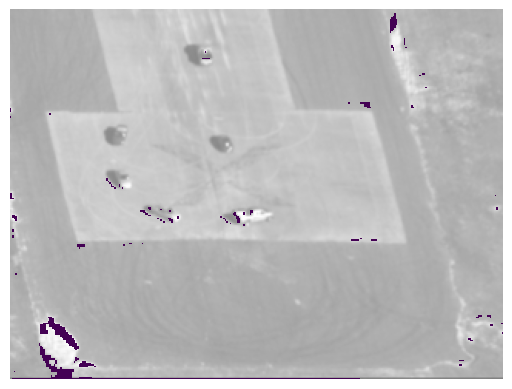

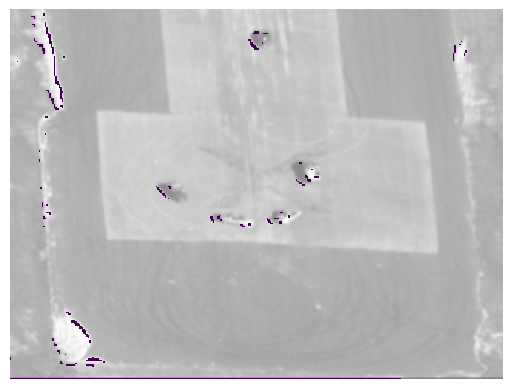

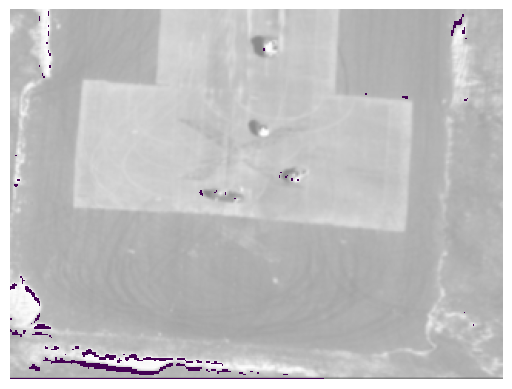

In [23]:
# TODO: visualize
frames_to_save = [30,60,90,120]

for idx in frames_to_save:
    frame = seq[:,:,idx]
    mask = masks[:,:,idx-1]
    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask))
    plt.axis('off')
    plt.savefig(f"C:\\Users\\balub\\OneDrive\\Desktop\\CV HW2\\aerialseq_images_Affine\\sol_2.3_aerialseq_{idx+1}.png")